In [76]:
import pandas as pd
import numpy as np
import time
import statsmodels.api as sm
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn import linear_model
from sklearn.feature_selection import SelectFromModel

## 데이터 불러오기

In [77]:
data = pd.read_csv("C:/mobile/train.csv")
data_test = pd.read_csv("C:/mobile/test.csv")

X = data.drop(columns='price_range')
y = data.price_range

train_x, test_x, train_y, test_y = train_test_split(X,y,train_size=0.7,test_size = 0.3)

print(train_x.shape)





(1400, 20)


## Correlation

In [78]:
corr = data.corr(method='pearson')
print(corr.price_range)

battery_power    0.200723
blue             0.020573
clock_speed     -0.006606
dual_sim         0.017444
fc               0.021998
four_g           0.014772
int_memory       0.044435
m_dep            0.000853
mobile_wt       -0.030302
n_cores          0.004399
pc               0.033599
px_height        0.148858
px_width         0.165818
ram              0.917046
sc_h             0.022986
sc_w             0.038711
talk_time        0.021859
three_g          0.023611
touch_screen    -0.030411
wifi             0.018785
price_range      1.000000
Name: price_range, dtype: float64


## Chi-square test

In [79]:
from scipy.stats import chi2_contingency

chi_list = []
for i in data.columns:
    chi_list.append(i)
    
print(chi_list)

chi_val_list = []
chi_p_list = []

for i in chi_list:
    contingency = pd.crosstab(data[i],data['price_range'])
    chi,p,dof,expected = chi2_contingency(contingency)
    chi_val_list.append(chi)
    chi_p_list.append(p)
    
chi_frame = {'chi':chi_val_list, 'p':chi_p_list}
chi_table = pd.DataFrame(chi_frame, index=chi_list)

print(chi_table)


['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g', 'touch_screen', 'wifi', 'price_range']
                       chi             p
battery_power  3415.466667  4.740658e-02
blue              1.432143  6.980178e-01
clock_speed      65.263542  7.814696e-01
dual_sim          1.286464  7.323497e-01
fc               61.798996  3.087122e-01
four_g            3.179880  3.647141e-01
int_memory      212.088414  9.204174e-02
m_dep            28.729129  3.741551e-01
mobile_wt       378.507288  2.410302e-01
n_cores          20.524450  4.882939e-01
pc               65.503970  2.917408e-01
px_height      3440.590476  3.440000e-01
px_width       3339.257143  4.226921e-01
ram            5404.666667  5.726601e-13
sc_h             45.169080  3.409697e-01
sc_w             78.995186  1.491460e-02
talk_time        37.563087  9.565969e-01
three_g           1.373764  7

## Forward feature selection

In [80]:
train_x = sm.add_constant(train_x)
model = sm.OLS(train_y,train_x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            price_range   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     808.2
Date:                Mon, 03 Oct 2022   Prob (F-statistic):               0.00
Time:                        21:21:16   Log-Likelihood:                -367.12
No. Observations:                1400   AIC:                             776.2
Df Residuals:                    1379   BIC:                             886.4
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.5511      0.072    -21.456

In [81]:
def processSubset(X,y,feature_set):
    model = sm.OLS(y,X[list(feature_set)]) # Modeling
    regr = model.fit() # model fitting
    AIC = regr.aic # model's AIC
    return {"model" : regr, "AIC" : AIC}

In [82]:
def getBest(X,y,k):
    tic = time.time()      # 시작 시간
    results = []           # 결과 저장 공간
    for combo in itertools.combinations(X.columns.difference(['const'],k)) :
		# 각 변수 조합을 고려한 경우의수
        
        combo = (list(combo)+['const'])
        # 상수항을 추가하여 combo를 결성
        
        results.append(processSubset(X,y,feature_set = combo)) # 모델링된것을 저장
        
        # 만약 k=2이면 여기서 두가지 변수만 뽑아서 경우의 수를 분석하여
        # 저장 후 그 중 AIC가 가장 낮은 모델을 선택하도록 함
	
    models = pd.DataFrame(results) # 데이터프레임으로 모델결과 변환
    best_model = models.loc[models['AIC'].argmin()] # argmin은 최소값의 인덱스를 뽑는 함수
    toc = time.time()       # 종료 시간
    print("Processed", models.shape[0], "models on", k, "predictors in",(toc - tic),"seconds.")
    
    return best_model

In [83]:
def forward(X,y,predictors):
	
    # predictor - 현재 선택되어있는 변수
    # 데이터 변수들이 미리정의된 predictors에 있는지 없는지 확인 및 분류
    
    remaining_predictors = [p for p in X.columns.difference(['const']) if p not in predictors]
    tic = time.time()
    results = []
    for p in remaining_predictors :
    	results.append(processSubset(X=X,y=y,feature_set=predictors+[p]+['const']))
    
    # 데이터프레임으로 변환
    models = pd.DataFrame(results)
    
    # AIC가 가장 낮은 것을 선택
    best_model = models.loc[models['AIC'].argmin()]
    toc = time.time()
    print("Processed ",models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic))
    print("Selected predictors:",best_model["model"].model.exog_names,"AIC: ",best_model[0])
    return best_model

In [84]:
def forward_model(X,y):

    Fmodels = pd.DataFrame(columns=["AIC","model"])
    tic = time.time()
    
    # 미리 정의된 데이터 변수
    predictors = []
    
    # 변수 1~10개 : 0-9 -> 1-10
    for i in range(1,len(X.columns.difference(['const']))+1):
        Forward_result = forward(X=X,y=y,predictors=predictors)
        if i > 1 :
            if Forward_result["AIC"] > Fmodel_before:
                break
        Fmodels.loc[i] = Forward_result
        predictors = Fmodels.loc[i]["model"].model.exog_names
        Fmodel_before = Fmodels.loc[i]["AIC"]
        predictors = [k for k in predictors if k != 'const']
    toc = time.time()
    print("Total elapsed time:",(toc-tic), "seconds.")
    
    return (Fmodels['model'][len(Fmodels['model'])])

In [85]:
Forward_best_model = forward_model(X=train_x,y=train_y)

Processed  20 models on 1 predictors in 0.03958845138549805
Selected predictors: ['ram', 'const'] AIC:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000002053B4820D0>
Processed  19 models on 2 predictors in 0.032120466232299805
Selected predictors: ['ram', 'battery_power', 'const'] AIC:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000002053B482A90>
Processed  18 models on 3 predictors in 0.023150920867919922
Selected predictors: ['ram', 'battery_power', 'px_width', 'const'] AIC:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000002053B47AF10>
Processed  17 models on 4 predictors in 0.019448280334472656
Selected predictors: ['ram', 'battery_power', 'px_width', 'px_height', 'const'] AIC:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000002053AF652B0>
Processed  16 models on 5 predictors in 0.023573637008666992
Selected predictors: ['ram', 'battery_power', 'px_width', 'px_he

In [11]:
Forward_best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            price_range   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     2262.
Date:                Mon, 03 Oct 2022   Prob (F-statistic):               0.00
Time:                        16:16:12   Log-Likelihood:                -386.38
No. Observations:                1400   AIC:                             788.8
Df Residuals:                    1392   BIC:                             830.7
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
ram               0.0010   7.89e-06    120.477      0.000       0.001       0.001
battery_power     0.0005   1.94e-05     27.253      0.000       0.000       0.001
px_height         0.0003   2.24e-05     12.735      0.000       0.000       0.000
px_width          0.0003   2.32e-05     12.564      0.000       0.000       0.000
mobile_wt        -0.0011      0.000     -4.516      0.000      -0.002      -0.001
int_memory        0.0010      0.000      2.149      0.032    8.94e-05       0.002
three_g           0.0387      0.020      1.921      0.055      -0.001       0.078
const            -1.6354      0.056    -29.100      0.000      -1.746      -1.525
==============================================================================
Omnibus:                       92.470   Durbin-Watson:                   1.902
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.407
Skew:                           0.039   Prob(JB):                     5.57e-08
Kurtosis:                       2.247   Cond. No.                     1.97e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.97e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Lasso Regression

In [97]:
alpha = 0.1
lasso = Lasso(alpha = alpha, max_iter = 10000).fit(train_x,train_y)
feature_list = lasso.feature_names_in_[lasso.coef_ != 0]

print(feature_list)



['battery_power' 'int_memory' 'mobile_wt' 'px_height' 'px_width' 'ram']


In [98]:
regressor = linear_model.Lasso(alpha=5000,positive=True,fit_intercept=False, max_iter=1000, tol=0.0001)
regressor.fit(train_x, train_y)

Lasso(alpha=5000, fit_intercept=False, positive=True)

In [99]:
import eli5
eli5.show_weights(regressor, top=1,feature_names = train_x.columns.tolist())

## PCA

In [100]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = scaler.fit_transform(train_x)

pca = PCA(n_components=4)
df_pca = pca.fit(df_scaled)

print(f"Explained Variance : {df_pca.explained_variance_ratio_}")


Explained Variance : [0.08459957 0.08165607 0.07796209 0.07211533]


결과 : best 4 features 는 
- ram              
- battery_power
- px_height
- px_width



##  전체 feature를 Logistic Regression

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report

In [31]:

train_x = train_x.drop(columns='const')

LR = LogisticRegression()
LR.fit(train_x,train_y)



C:\Users\shjoo\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [101]:
y_pred = LR.predict(test_x)
accuracy_score(test_y,y_pred)


0.6466666666666666

## best 4 features만 Logistic Regression

In [102]:
newX = data[['ram','battery_power','px_height','px_width']]
newy = data.price_range

train_x, test_x, train_y, test_y = train_test_split(newX,newy,train_size=0.7,test_size = 0.3)


In [103]:
LR2 = LogisticRegression()
LR2.fit(train_x,train_y)

y_pred2 = LR2.predict(test_x)
accuracy_score(test_y,y_pred2)


C:\Users\shjoo\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.945

## PCA / t-SNE을 이용하여 training data를 visualization 하여 비교

In [53]:
data = pd.read_csv("C:/mobile/train.csv")
data_test = pd.read_csv("C:/mobile/test.csv")



### PCA

      battery_power  blue  clock_speed  dual_sim  fc  four_g  int_memory  \
0               842     0          2.2         0   1       0           7   
1              1021     1          0.5         1   0       1          53   
2               563     1          0.5         1   2       1          41   
3               615     1          2.5         0   0       0          10   
4              1821     1          1.2         0  13       1          44   
...             ...   ...          ...       ...  ..     ...         ...   
1995            794     1          0.5         1   0       1           2   
1996           1965     1          2.6         1   0       0          39   
1997           1911     0          0.9         1   1       1          36   
1998           1512     0          0.9         0   4       1          46   
1999            510     1          2.0         1   5       1          45   

      m_dep  mobile_wt  n_cores  pc  px_height  px_width   ram  sc_h  sc_w  \
0       0

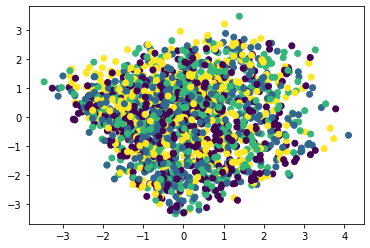

In [104]:

X = data.drop(columns='price_range')
print(X)

y = data.price_range

# train_x, test_x, train_y, test_y = train_test_split(X,y,train_size=0.7,test_size = 0.3)

# X

from sklearn.preprocessing import StandardScaler

X_ = StandardScaler().fit_transform(X)

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pc = pca.fit_transform(X_)

pc_y = np.c_[pc,y]
df = pd.DataFrame(pc_y,columns=['PC1','PC2','price_range'])

plt.scatter(x=df['PC1'],y=df['PC2'],c=df['price_range'])



# scaler = StandardScaler()
# scaler.fit(data)
# data_scaled = scaler.transform(data)

# data_scaled = pd.DataFrame(data_scaled, columns = data.iloc[:,19])
# data_scaled
# # df_scaled['target'] = data['price_range']
# # df_scaled

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

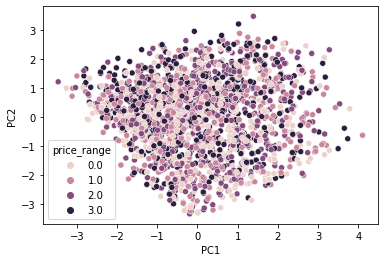

In [105]:
import seaborn as sns
sns.scatterplot(data = df, x='PC1',y='PC2',hue='price_range')

### t-SNE

In [109]:
import time
from sklearn.manifold import TSNE

train_df = X

tsne_np = TSNE(n_components = 2).fit_transform(train_df)

tsne_df = pd.DataFrame(tsne_np,columns =['component0','component1'])

tsne_df['target'] = y

tsne_df

C:\Users\shjoo\AppData\Roaming\Python\Python38\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\shjoo\AppData\Roaming\Python\Python38\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


,component0,component1,target
0,-14.670969,14.939633,1
1,25.082691,-7.321947,2
2,31.119312,-8.170747,2
3,32.167953,-6.899659,2
4,5.792039,-29.756765,1
...,...,...,...
1995,-6.030779,-44.420010,0
1996,10.808814,-21.424377,2
1997,20.903040,4.173275,3
1998,-35.906975,-21.219530,0


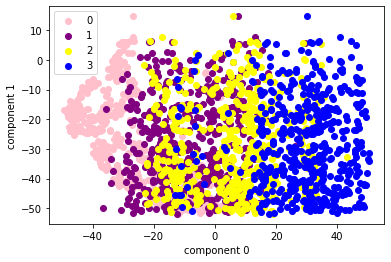

In [110]:
tsne_df_0 = tsne_df[tsne_df['target'] == 0]
tsne_df_1 = tsne_df[tsne_df['target'] == 1]
tsne_df_2 = tsne_df[tsne_df['target'] == 2]
tsne_df_3 = tsne_df[tsne_df['target'] == 3]

plt.scatter(tsne_df_0['component0'],tsne_df_0['component1'], color = 'pink',label = '0')
plt.scatter(tsne_df_1['component0'],tsne_df_0['component1'], color = 'purple',label = '1')
plt.scatter(tsne_df_2['component0'],tsne_df_0['component1'], color = 'yellow',label = '2')
plt.scatter(tsne_df_3['component0'],tsne_df_0['component1'], color = 'blue',label = '3')

plt.xlabel('component 0')
plt.ylabel('component 1')
plt.legend()
plt.show()